In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
import networkx as nx
from scipy.spatial import distance
from tqdm import tqdm

# Экспоненциальное распределение
def generate_exponential_samples(n, lambda_param):
    samples = np.random.exponential(1/lambda_param, n)
    return samples

# Гамма распределение
def generate_gamma_samples(n, lambda_param):
    alpha = 1 / 2
    samples = np.random.gamma(alpha, 1 / lambda_param, n)
    return samples

#Генерация Normal(0,σ);
def generate_normal_samles(size, loc=0, scale=1):
    return np.random.normal(loc, scale, size)

#Генерация Student-t(ν)
def generate_standard_t_samles(size, df=3):
    return np.random.standard_t(df, size)

# Построение knn-графа
def generate_knn_digraph(sample, k):
    G = nx.DiGraph()
    sample = np.asarray(sample)
    if sample.ndim == 1:
        sample = sample.reshape(-1, 1)

    n_samples = len(sample)
    if k >= n_samples - 1:
        G.add_nodes_from(range(n_samples))
        for i in range(n_samples):
            for j in range(n_samples):
                if i != j:
                    G.add_edge(i, j)
        return G
    G.add_nodes_from(range(n_samples))
    dist_matrix = distance.squareform(distance.pdist(sample))
    for i in range(n_samples):
      neighbors = np.argsort(dist_matrix[i])[1:k+1]
      for neighbor in neighbors:
        G.add_edge(i, neighbor)
    return G

# Построение дистанционного графа
def generate_distance_graph(sample, d):
    G = nx.Graph()

    for i in range(len(sample)):
        G.add_node(i, pos=(sample[i], 0))

    for i in range(len(sample)):
        for j in range(i + 1, len(sample)):
            if abs(sample[i] - sample[j]) <= d:
                G.add_edge(i, j)
    '''
    pos = nx.get_node_attributes(G, 'pos')
    plt.figure(figsize=(10, 6))
    nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=500, font_size=10)
    plt.title(f'Distance Graph with d = {d}')
    plt.xlabel('Sample Values')
    plt.yticks([])
    plt.show()
    '''
    return G

# макс степень вершины
def max_node_degree(graph):
    if not graph:
        return 0

    degrees = dict(graph.degree())
    max_degree = max(degrees.values())
    return max_degree

# макс. независимое множество UML-диаграмма реализованных классо UML-диаграмма реализованных классо
def max_independent_set_size(graph):
    if not graph:
        return 0
    independent_set = nx.algorithms.approximation.maximum_independent_set(graph)
    return len(independent_set)

#δ(G) - минимальная степень
def min_node_degree(graph):
    if not graph:
        return 0
    degrees = dict(graph.in_degree())
    return min(degrees.values())

#χ(G) - Хроматическое число
def chromatic_number(graph):
    if not graph:
        return 0
    coloring = nx.algorithms.coloring.greedy_color(graph, strategy='largest_first', interchange=True)
    return max(coloring.values()) + 1

In [21]:
def frequencies(T_H0, T_H1):
  P=[]
  for value in list(set(T_H0) | set(T_H1)):
    P.append([value, T_H0.count(value)/len(T_H0), T_H1.count(value)/len(T_H1)])
  return P

def sort_key(triple):
    _, b, c = triple
    if b == 0:
        return (float('-inf'),)
    return (-(c / b),)

def greedy(T_H0, T_H1, alpha=0.055):
  P = frequencies(T_H0, T_H1) #Массив частот значений(условно вероятностей)
  P.sort(key=sort_key)# Сортируем элементы по убыванию P(H_1)/P(H_0).
  #Теперь построим множество А. Но для удобства будем строить его дополнение.
  A=[]
  current_error = 0
  power = 0
  for value, p0, p1 in P:
    if current_error + p0< alpha:
      current_error+=p0
      power+=p1
      A.append(value)
    else:
      break
  A= (set(T_H0) | set(T_H1)).difference(set(A))
  return A, current_error, power

**Исследование важности характеристик, как признаков классификации.
Изучить меняется ли важность характеристик с ростом n.**

Добавим функции для генерации значений для максимальной степени и размера макс. независимого мн-ва.

In [24]:
def generate_values_max_degrees(n=500, n_trials=1000, d=1):
  T_H0=[]
  T_H1=[]
  for _ in range(n_trials):
    samples_1 = generate_exponential_samples(n, 1)
    samples_2 = generate_gamma_samples(n, 1/np.sqrt(2))
    G = generate_distance_graph(samples_1, d)
    max_degree_1 = max_node_degree(G)
    G = generate_distance_graph(samples_2, d)
    max_degree_2 = max_node_degree(G)
    T_H0.append(max_degree_1)
    T_H1.append(max_degree_2)
  return T_H0, T_H1

def generate_values_ind(n=500, n_trials=1000, d=1):
  T_H0=[]
  T_H1=[]
  for _ in range(n_trials):
    samples_1 = generate_exponential_samples(n, 1)
    samples_2 = generate_gamma_samples(n, 1/np.sqrt(2))
    G = generate_distance_graph(samples_1, d)
    ind_1 = max_independent_set_size(G)
    G = generate_distance_graph(samples_2, d)
    ind_2 = max_independent_set_size(G)
    T_H0.append(ind_1)
    T_H1.append(ind_2)
  return T_H0, T_H1

Исследуем важность характеристик на dist графе.

Processing sample size: 100%|██████████| 7/7 [06:33<00:00, 56.27s/it] 


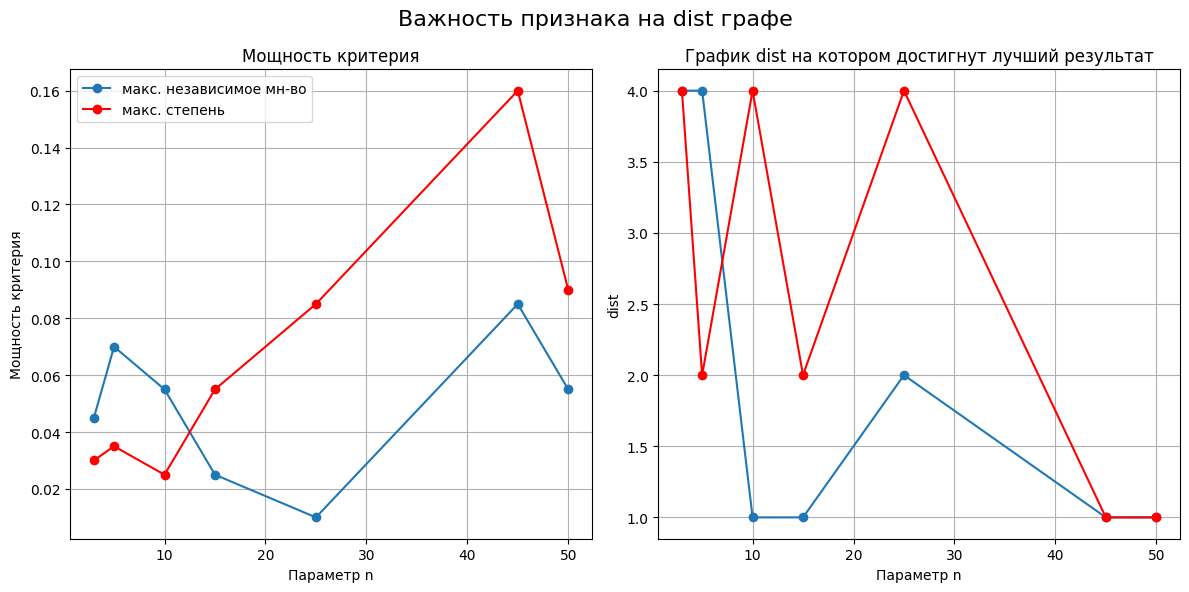

In [28]:
param_grid = {
    'n': [3, 5, 10, 15, 25, 45, 50],
    'd': [1, 2, 4, 7, 10]
}
np.random.seed(42)
powers_ind = []
dists_ind = []
powers_max_degrees = []
dists_max_degrees = []
for n in tqdm(param_grid['n'], desc='Processing sample size'):
  #max indep. set
  best_power = -1
  best_dist = -1
  for d in param_grid['d']:
    T_H0, T_H1 = generate_values_ind(n, 200, d)
    A, current_error, power = greedy(T_H0, T_H1, 0.055)
    if power>best_power:
      best_power=power
      best_dist = d
  powers_ind.append(best_power)
  dists_ind.append(best_dist)
  # max degrees
  best_power = -1
  best_dist = -1
  for d in param_grid['d']:
    T_H0, T_H1 = generate_values_max_degrees(n, 200, d)
    A, current_error, power = greedy(T_H0, T_H1, 0.055)
    if power>best_power:
      best_power=power
      best_dist = d
  powers_max_degrees.append(best_power)
  dists_max_degrees.append(best_dist)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
fig.suptitle('Важность признака на dist графе', fontsize=16)


ax = axes[0]
ax.plot(param_grid['n'], powers_ind, marker='o', label='макс. независимое мн-во')
ax.plot(param_grid['n'], powers_max_degrees, marker='o', color='red', label='макс. степень')
ax.set_title(f'Мощность критерия')
ax.set_xlabel('Параметр n')
ax.set_ylabel('Мощность критерия')
ax.legend()
ax.grid(True)

ax = axes[1]
ax.plot(param_grid['n'], dists_ind, marker='o', label='макс. независимое мн-во')
ax.plot(param_grid['n'], dists_max_degrees, marker='o', color='red', label='макс. степень')
ax.set_title(f'График dist на котором достигнут лучший результат')
ax.set_xlabel('Параметр n')
ax.set_ylabel('dist')
ax.grid(True)

plt.tight_layout()
plt.show()


In [29]:
import random
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

class Classifier():
    def __init__(self, alpha=0.055):
        self.alpha = alpha
        self.A0 = []
        self.A1 = []

    def fit(self, X_train, y_train):
        T_H0 = list(X_train['max_degrees'][y_train == 1])
        T_H1 = list(X_train['max_degrees'][y_train == 0])
        self.A0, _, _ = greedy(T_H0, T_H1, self.alpha)

        T_H0 = list(X_train['ind'][y_train == 1])
        T_H1 = list(X_train['ind'][y_train == 0])
        self.A1, _, _ = greedy(T_H0, T_H1, self.alpha)

    def predict(self, X_test):
        y_pred = []
        for _, row in X_test.iterrows():
            if row['max_degrees'] in self.A0 and row['ind'] in self.A1:
                y_pred.append(1)
            elif row['max_degrees'] in self.A0 or row['ind'] in self.A1:
              y_pred.append(random.choice([0, 1]))
            else:
              y_pred.append(0)

        return y_pred

Начнем с LogisticRegression.

In [34]:
def fast_max_independent_set_size(graph):
    if not graph:
        return 0

    independent_set = set()
    nodes = set(graph.nodes())

    while nodes:
        node = nodes.pop()
        independent_set.add(node)
        neighbors = set(graph.neighbors(node))
        nodes.difference_update(neighbors)

    return len(independent_set)

In [39]:
import pandas as pd
from tqdm import tqdm
data = {}
n_samples = [500, 100, 25]
for n in tqdm(n_samples):
  max_degrees = []
  inds = []
  classes = []
  for _ in range(1000):
    sample_exp = generate_exponential_samples(n, 1)
    sample_Gamma = generate_gamma_samples(n, 1/np.sqrt(2))

    G = generate_distance_graph(sample_exp, d=4)
    sample_exp_max_degree = max_node_degree(G)
    G = generate_distance_graph(sample_Gamma, d=4)
    sample_Gamma_max_degree = max_node_degree(G)
    G = generate_distance_graph(sample_exp, d=4)
    sample_exp_ind = fast_max_independent_set_size(G)
    G = generate_distance_graph(sample_Gamma, d=4)
    sample_Gamma_ind = fast_max_independent_set_size(G)

    max_degrees.append(sample_exp_max_degree)
    max_degrees.append(sample_Gamma_max_degree)
    inds.append(sample_exp_ind)
    inds.append(sample_Gamma_ind)
    classes.append(1)
    classes.append(0)
  df = pd.DataFrame({
    'max_degrees': max_degrees,
    'ind': inds,
    'class': classes
  })
  data[n] = df



100%|██████████| 3/3 [14:26<00:00, 288.68s/it]


In [40]:
from sklearn.utils import resample

def bootstrap_metrics(X_test, y_test, classifier, B=100):
    metrics = {'Accuracy': [], 'Recall': [], 'Precision': [], 'F1': []}
    for _ in range(B):
        X_bs, y_bs = resample(X_test, y_test, replace=True)
        y_pred = classifier.predict(X_bs)
        metrics['Accuracy'].append(accuracy_score(y_bs, y_pred))
        metrics['Recall'].append(recall_score(y_bs, y_pred))
        metrics['Precision'].append(precision_score(y_bs, y_pred))
        metrics['F1'].append(f1_score(y_bs, y_pred))

    return metrics
    for name, values in metrics.items():
        print(f"{name}: mean = {np.mean(values):.3f}, std = {np.std(values):.3f}")

In [41]:
metrics_lr = {
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1': []
}

metrics_lr_d = {
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1': []
}

metrics_rf = {
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1': []
}

metrics_rf_d = {
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1': []
}

metrics_my = {
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1': []
}

metrics_my_d = {
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1': []
}

for n in tqdm(n_samples):
  X_train, X_test, y_train, y_test = train_test_split(
    data[n][['max_degrees', 'ind']], data[n]['class'], test_size=0.3, random_state=42
  )
  model = LogisticRegression(max_iter=1000, penalty='l2')
  model.fit(X_train, y_train)

  temp = bootstrap_metrics(X_test, y_test, model)
  for name, values in temp.items():
        metrics_lr[name].append(np.round(np.mean(values), 4))
        metrics_lr_d[name].append(np.round(np.std(values), 4))

  model = RandomForestClassifier(
    n_estimators=50,
    max_depth=None,
    max_features=2,
    min_samples_split=2,
    random_state=42
  )
  model.fit(X_train, y_train)

  temp = bootstrap_metrics(X_test, y_test, model)
  for name, values in temp.items():
        metrics_rf[name].append(np.round(np.mean(values), 4))
        metrics_rf_d[name].append(np.round(np.std(values), 4))

  model = Classifier()
  model.fit(X_train, y_train)

  temp = bootstrap_metrics(X_test, y_test, model)
  for name, values in temp.items():
        metrics_my[name].append(np.round(np.mean(values), 4))
        metrics_my_d[name].append(np.round(np.std(values), 4))



100%|██████████| 3/3 [00:16<00:00,  5.57s/it]


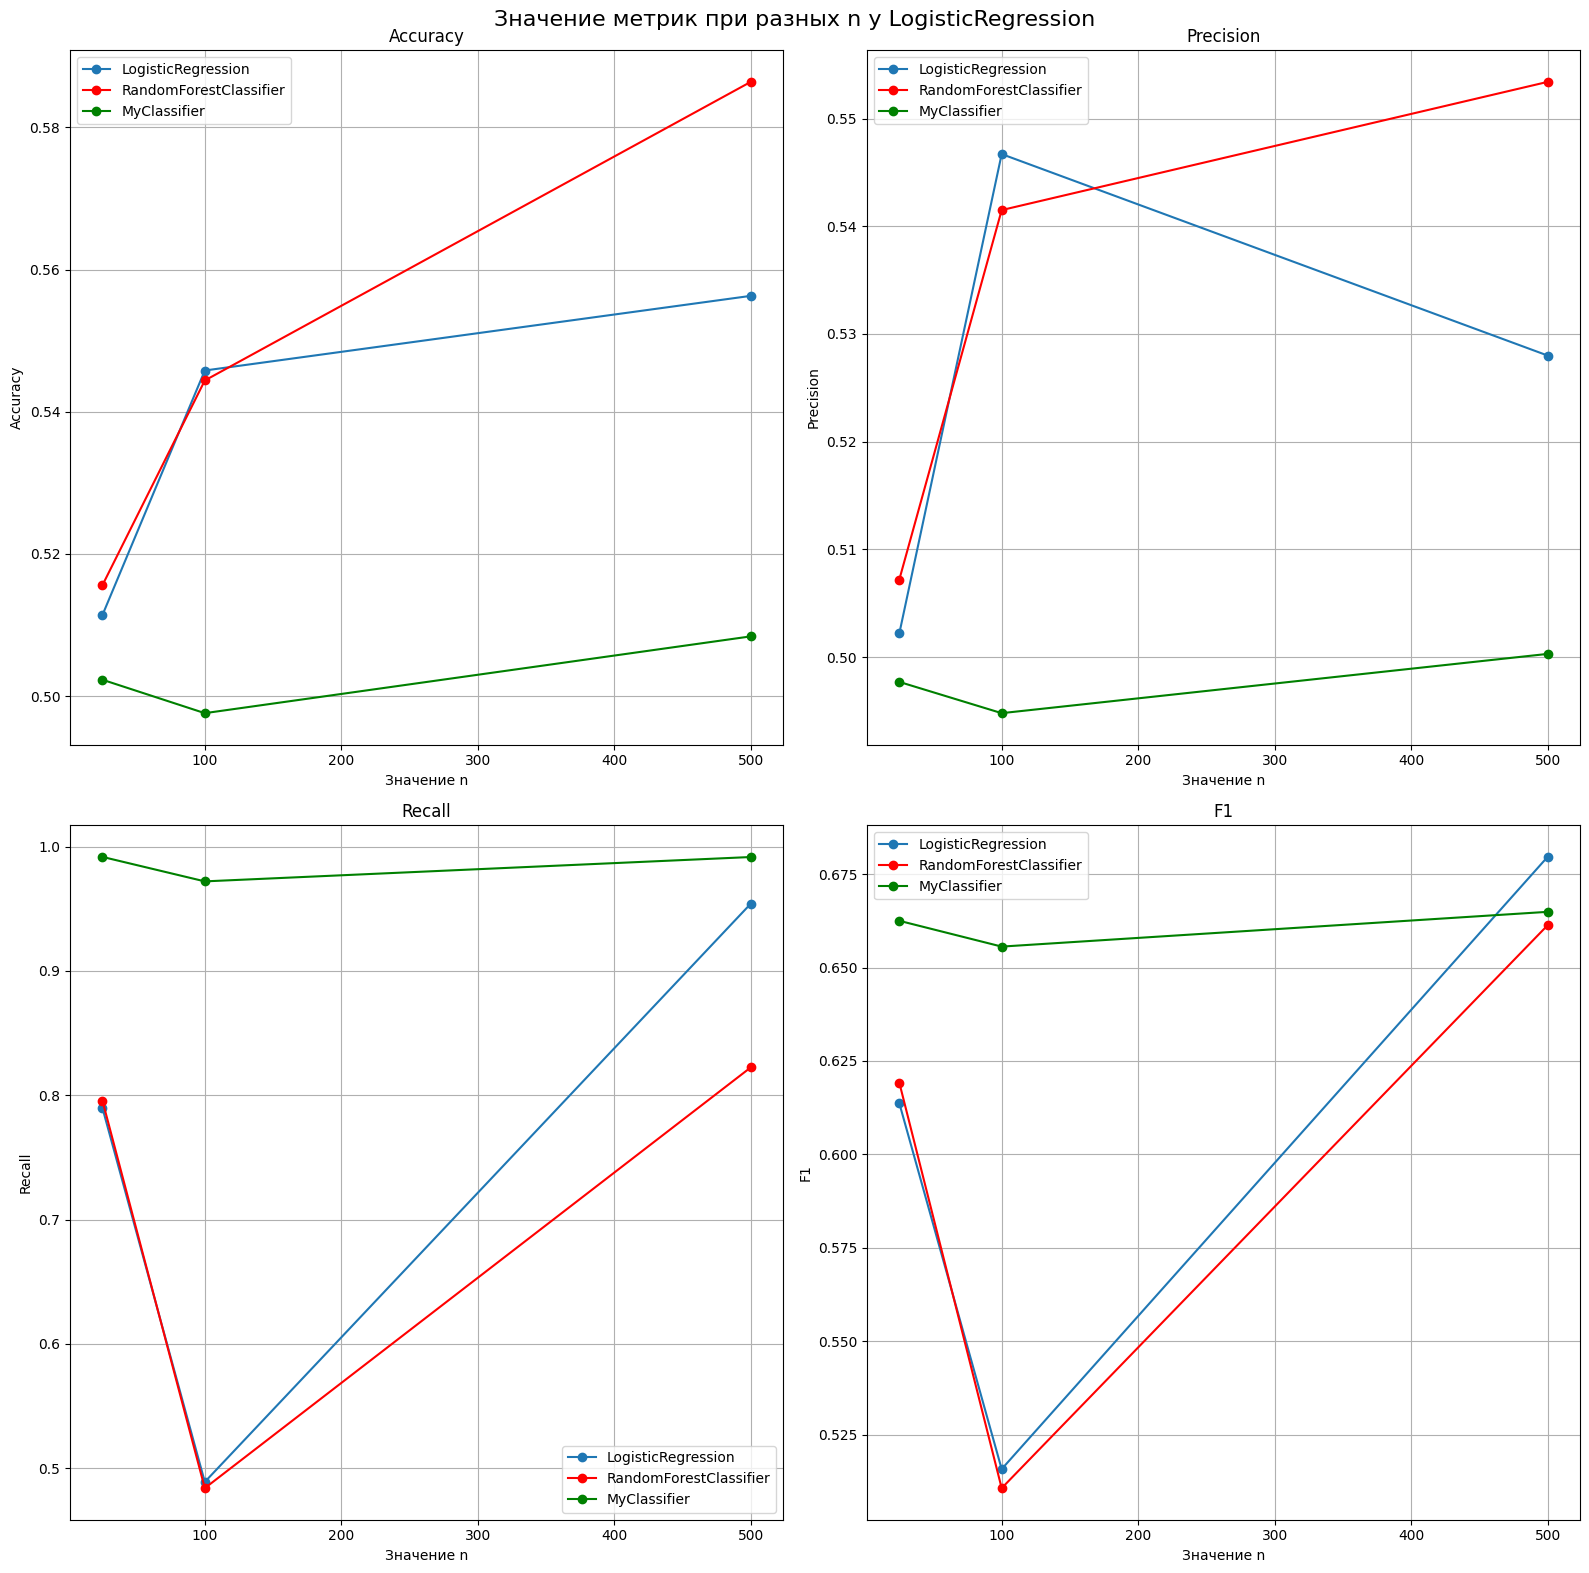

In [45]:
  fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 16))
  fig.suptitle('Значение метрик при разных n у LogisticRegression', fontsize=16)

  ax = axes[0, 0]
  ax.plot(n_samples, metrics_lr['Accuracy'], marker='o', label='LogisticRegression')
  ax.plot(n_samples, metrics_rf['Accuracy'], marker='o', label='RandomForestClassifier', color='red')
  ax.plot(n_samples, metrics_my['Accuracy'], marker='o', label='MyClassifier', color='green')
  ax.set_title(f'Accuracy')
  ax.set_xlabel('Значение n')
  ax.set_ylabel('Accuracy')
  ax.legend()
  ax.grid(True)

  ax = axes[0, 1]
  ax.plot(n_samples, metrics_lr['Precision'], marker='o', label='LogisticRegression')
  ax.plot(n_samples, metrics_rf['Precision'], marker='o', label='RandomForestClassifier', color='red')
  ax.plot(n_samples, metrics_my['Precision'], marker='o', label='MyClassifier', color='green')
  ax.set_title(f'Precision')
  ax.set_xlabel('Значение n')
  ax.set_ylabel('Precision')
  ax.legend()
  ax.grid(True)

  ax = axes[1, 0]
  ax.plot(n_samples, metrics_lr['Recall'], marker='o', label='LogisticRegression')
  ax.plot(n_samples, metrics_rf['Recall'], marker='o', label='RandomForestClassifier', color='red')
  ax.plot(n_samples, metrics_my['Recall'], marker='o', label='MyClassifier', color='green')
  ax.set_title(f'Recall')
  ax.set_xlabel('Значение n')
  ax.set_ylabel('Recall')
  ax.legend()
  ax.grid(True)

  ax = axes[1, 1]
  ax.plot(n_samples, metrics_lr['F1'], marker='o', label='LogisticRegression')
  ax.plot(n_samples, metrics_rf['F1'], marker='o', label='RandomForestClassifier', color='red')
  ax.plot(n_samples, metrics_my['F1'], marker='o', label='MyClassifier', color='green')
  ax.set_title(f'F1')
  ax.set_xlabel('Значение n')
  ax.set_ylabel('F1')
  ax.legend()
  ax.grid(True)


  plt.tight_layout()
  plt.show()

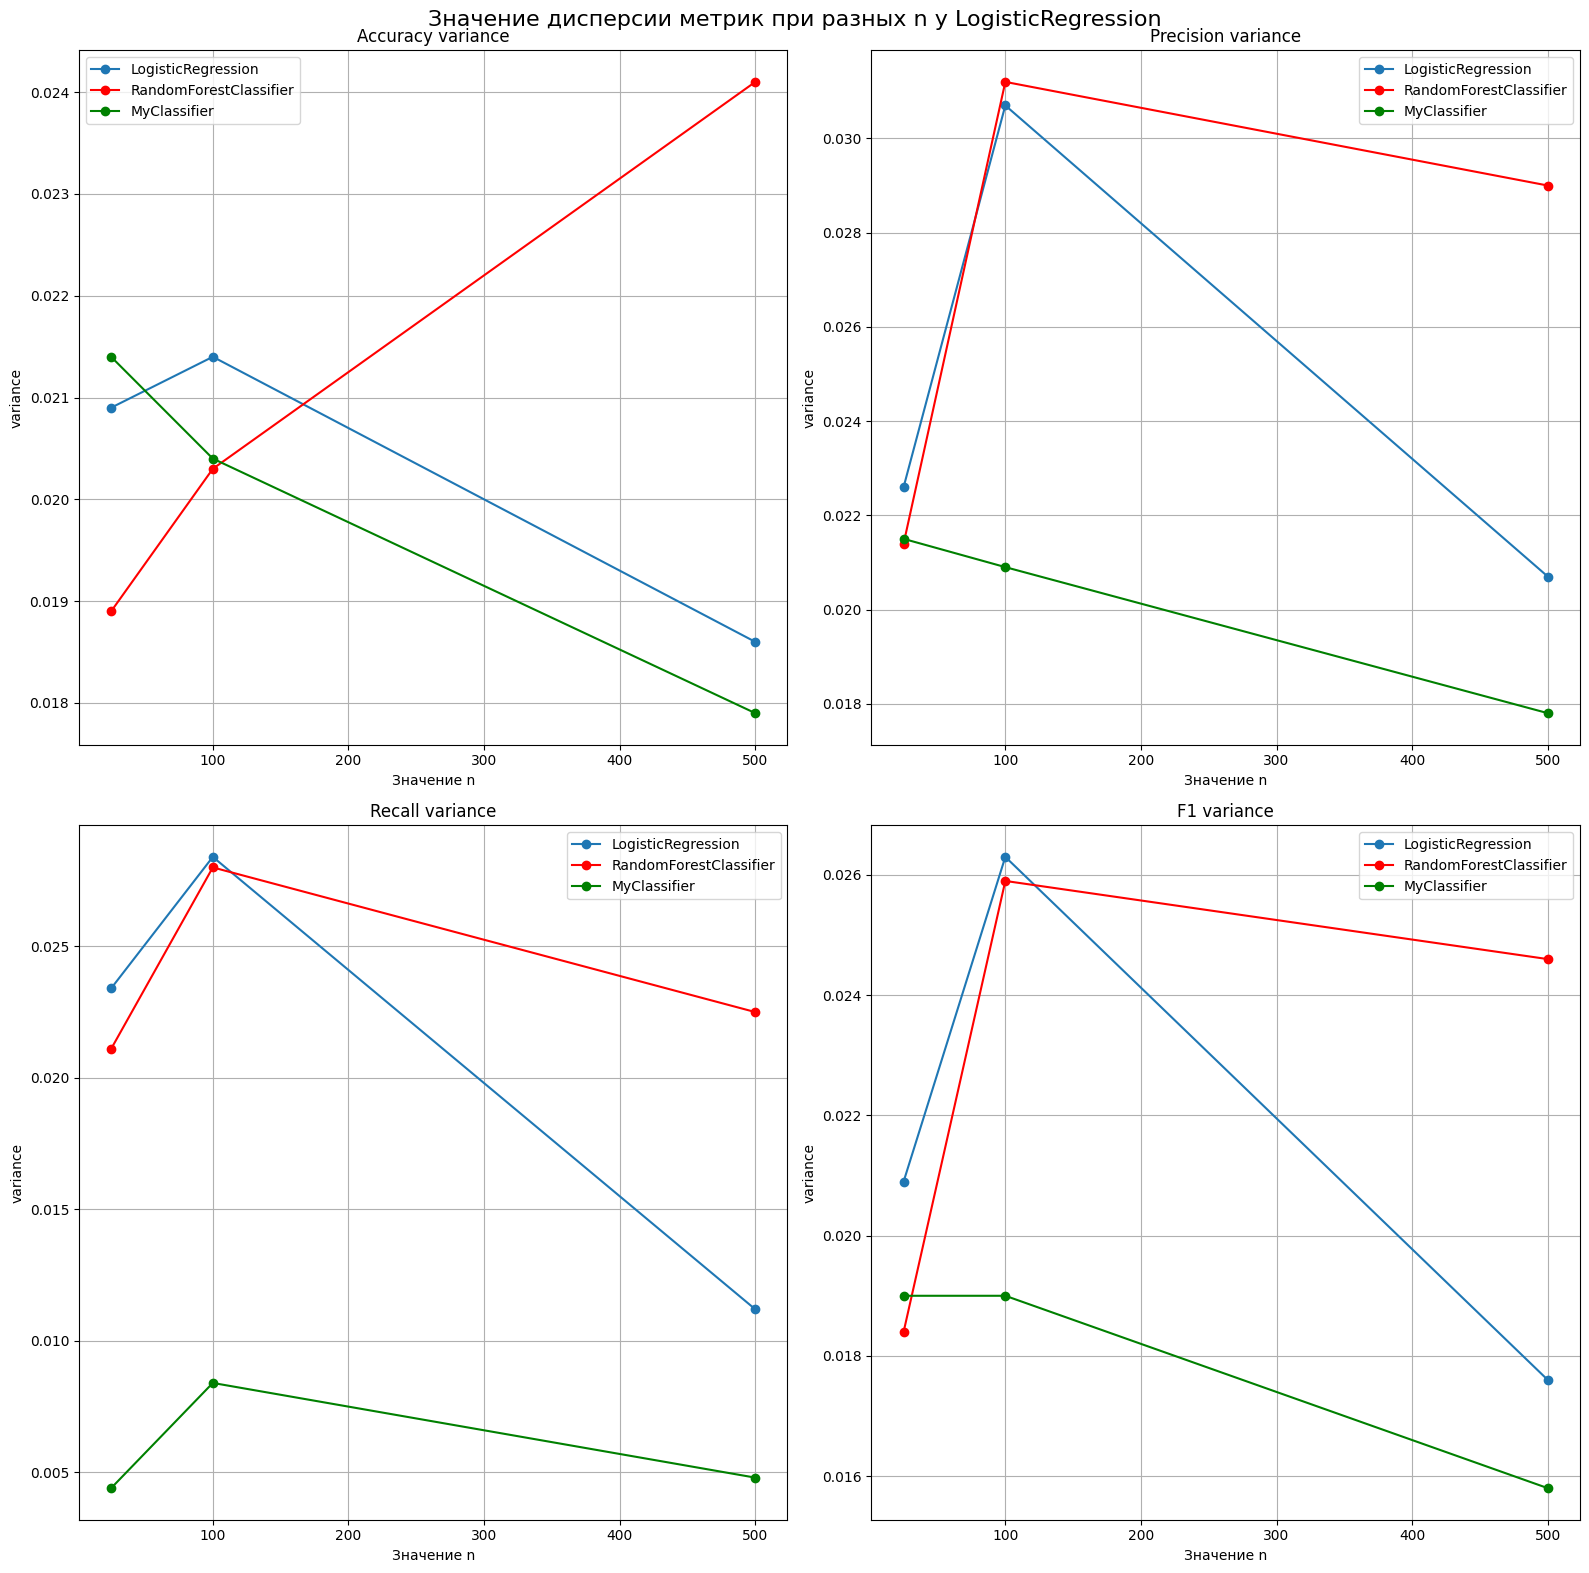

In [43]:
  fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 16))
  fig.suptitle('Значение дисперсии метрик при разных n у LogisticRegression', fontsize=16)


  ax = axes[0, 0]
  ax.plot(n_samples, metrics_lr_d['Accuracy'], marker='o', label='LogisticRegression')
  ax.plot(n_samples, metrics_rf_d['Accuracy'], marker='o', label='RandomForestClassifier', color='red')
  ax.plot(n_samples, metrics_my_d['Accuracy'], marker='o', label='MyClassifier', color='green')
  ax.set_title(f'Accuracy variance')
  ax.set_xlabel('Значение n')
  ax.set_ylabel('variance')
  ax.legend()
  ax.grid(True)

  ax = axes[0, 1]
  ax.plot(n_samples, metrics_lr_d['Precision'], marker='o', label='LogisticRegression')
  ax.plot(n_samples, metrics_rf_d['Precision'], marker='o', label='RandomForestClassifier', color='red')
  ax.plot(n_samples, metrics_my_d['Precision'], marker='o', label='MyClassifier', color='green')
  ax.set_title(f'Precision variance')
  ax.set_xlabel('Значение n')
  ax.set_ylabel('variance')
  ax.legend()
  ax.grid(True)

  ax = axes[1, 0]
  ax.plot(n_samples, metrics_lr_d['Recall'], marker='o', label='LogisticRegression')
  ax.plot(n_samples, metrics_rf_d['Recall'], marker='o', label='RandomForestClassifier', color='red')
  ax.plot(n_samples, metrics_my_d['Recall'], marker='o', label='MyClassifier', color='green')
  ax.set_title(f'Recall variance')
  ax.set_xlabel('Значение n')
  ax.set_ylabel('variance')
  ax.legend()
  ax.grid(True)

  ax = axes[1, 1]
  ax.plot(n_samples, metrics_lr_d['F1'], marker='o', label='LogisticRegression')
  ax.plot(n_samples, metrics_rf_d['F1'], marker='o', label='RandomForestClassifier', color='red')
  ax.plot(n_samples, metrics_my_d['F1'], marker='o', label='MyClassifier', color='green')
  ax.set_title(f'F1 variance')
  ax.set_xlabel('Значение n')
  ax.set_ylabel('variance')
  ax.legend()
  ax.grid(True)


  plt.tight_layout()
  plt.show()